# ***Inflation and interest rates: analysing and modeling for Brazil***

## Objectives

Collect initial data on brazilian inflation (measured by IPCA, off. price index) and interest rate (SELIC, main tax of BR economy). Then, we will collect a series of other data to estimate and model the relationships between SELIC and IPCA, controlling for other variables.

## Data base

IBGE, Ipea Data, BCB, and others.

## References

Books on Macroeconomic Theory and Econometrics (for models):

    - FROYEN, Richard T. Macroeconomics: Theories and policies. 2013.

    - BLANCHARD, Olivier. Macroeconomics. Pearson Higher Education, 2013.

    - WOOLDRIDGE, Jeffrey M. Introductory econometrics: A modern approach. Cengage learning, 2015.

Codes, pages, tutorials, documentations, etc:

- Doc. python-bcb: https://pypi.org/project/python-bcb/

- Doc. Sidra Python (sidrapy): https://github.com/AlanTaranti/sidrapy

- Análise Macro (example data pooling): https://analisemacro.com.br/economia/indicadores/coletando-dados-da-selic-com-o-python/

- Colab code: https://colab.research.google.com/drive/1_t6-vO_Mv1Iv_4Wykexeb81FJkOPY-CI

# Importing packages and API's
---

In [2]:
# %pip install python-bcb
# %pip install sidrapy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from bcb import sgs # Importing the module for Time Series Analysis of BCB
import sidrapy

# Getting and initially exploring data on SELIC and IPCA

Searching for time series on Selic Meta (rate defined at COPOM) and for IPCA full month-to-month index. 

Series consulting codes at BCB:

- Selic Meta: 432

- IPCA total: 433

Series consulting codes at SIDRA IBGE:

- IPCA tabela geral: 1737

For inflation measured by IPCA, we use data from SIDRA, because series for 12 month variations month to month is already calculated, avoiding a code part to make this manipulation.

In [4]:
selic_meta = sgs.get(('selic', 432), start='2010-01-01')
selic_meta.reset_index(inplace=True)
print(selic_meta.head(), selic_meta.columns, selic_meta.index, sep='\n')

        Date  selic
0 2010-01-01   8.75
1 2010-01-02   8.75
2 2010-01-03   8.75
3 2010-01-04   8.75
4 2010-01-05   8.75
Index(['Date', 'selic'], dtype='object')
RangeIndex(start=0, stop=4556, step=1)


Collecting IPCA series (1737), at country level (1), in all country (all), at month, 3 months cumulated, 6 months cumulated and 12 months cumulated (63, 69, 2263, 2264, 2265).

In [5]:
ipca_raw = sidrapy.get_table(
    table_code='1737',
    territorial_level='1',
    ibge_territorial_code='all',
    variable='63,69,2263,2264,2265',
    period='last%20472'
)

In [6]:
ipca =  (
    ipca_raw
    .loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'}
            )
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float)
           )
    .pipe(lambda x: x.loc[x.date > '2009-12-01']
          )
        )
ipca

,value,date,variable
1616,0.75,2010-01-01,Var. mensal (%)
1617,0.75,2010-01-01,Var. acumulada no ano (%)
1618,1.54,2010-01-01,Var. MM3M (%)
1619,2.46,2010-01-01,Var. MM6M (%)
1620,4.59,2010-01-01,Var. MM12M (%)
...,...,...,...
2356,0.47,2022-05-01,Var. mensal (%)
2357,4.78,2022-05-01,Var. acumulada no ano (%)
2358,3.18,2022-05-01,Var. MM3M (%)
2359,5.55,2022-05-01,Var. MM6M (%)


In [7]:
ipca_12m = ipca[ipca.variable == 'Var. MM12M (%)']
ipca_12m.reset_index(inplace=True)
ipca_12m.drop(['variable', 'index'], axis=1, inplace=True)
ipca_12m.columns = ['ipca', 'Date']
ipca_12m.head()

C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ipca,Date
0,4.59,2010-01-01
1,4.83,2010-02-01
2,5.17,2010-03-01
3,5.26,2010-04-01
4,5.22,2010-05-01


In [8]:
'''ipca_full = sgs.get(('ipca', 433), start='')
print(ipca_full.head(), ipca_full.columns, ipca_full.index, sep='\n')'''

"ipca_full = sgs.get(('ipca', 433), start='')\nprint(ipca_full.head(), ipca_full.columns, ipca_full.index, sep='\n')"

## Visualization

In [9]:
print(selic_meta.shape, ipca_12m.shape)

(4556, 2) (149, 2)


Text(0, 0.5, 'Value p.p')

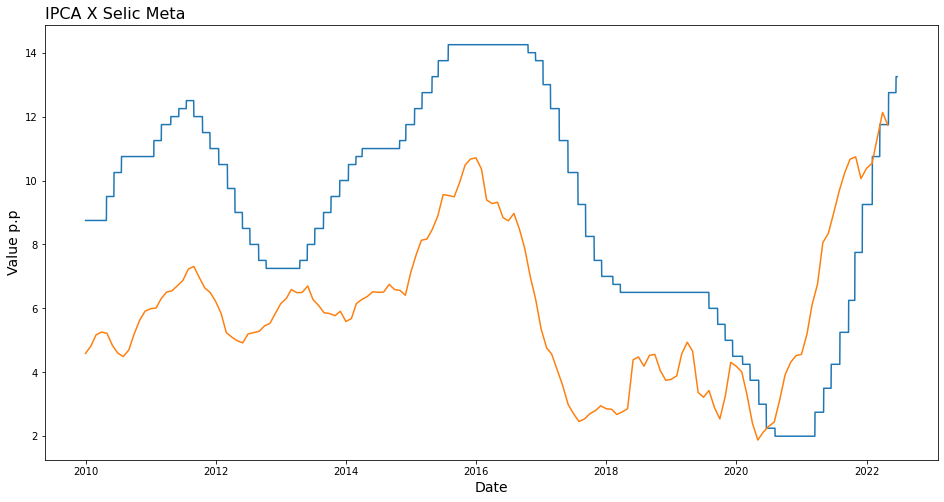

In [10]:
plt.figure(figsize=(16,8))
plt.plot(selic_meta.Date, selic_meta.selic, label='Selic Meta a.a %')
plt.plot(ipca_12m.Date, ipca_12m.ipca, label='Full IPCA - m.m %')
plt.title('IPCA X Selic Meta', fontsize=16, loc='left')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value p.p', fontsize=14)

# Data manipulations
---

In [11]:
monetary_data = pd.merge(ipca_12m, selic_meta, how='inner', left_on='Date', right_on='Date')
date = monetary_data.pop('Date')
monetary_data.insert(0, 'date', date)
monetary_data

,date,ipca,selic
0,2010-01-01,4.59,8.75
1,2010-02-01,4.83,8.75
2,2010-03-01,5.17,8.75
3,2010-04-01,5.26,8.75
4,2010-05-01,5.22,9.50
...,...,...,...
144,2022-01-01,10.38,9.25
145,2022-02-01,10.54,9.25
146,2022-03-01,11.30,10.75
147,2022-04-01,12.13,11.75


## Visualization

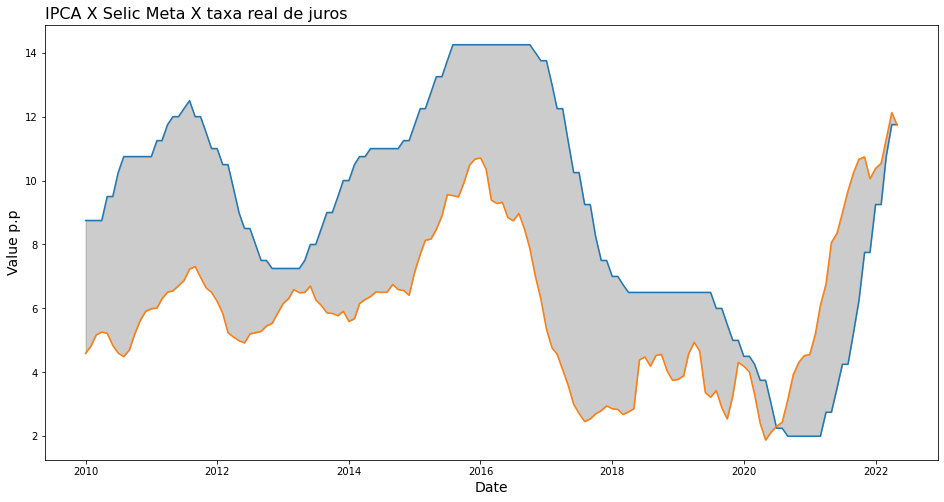

In [12]:
plt.figure(figsize=(16,8))
plt.plot(monetary_data.date, monetary_data.selic, label='Selic Meta a.a %')
plt.plot(monetary_data.date, monetary_data.ipca, label='Full IPCA - m.m %')
plt.fill_between(monetary_data.date, monetary_data.selic, monetary_data.ipca, color='k', alpha=0.2)
plt.title('IPCA X Selic Meta X taxa real de juros', fontsize=16, loc='left')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value p.p', fontsize=14)
plt.show()

# Simple Regression on interest and inflation rates
---

# Collecting more data to nowcast GDP
---

## Description

Em primeiro momento, serão coletadas 10 variáveis, além da variável-alvo, o PIB, para fazermos as previsões. As variáveis selecionadas estão em linha com a intuição, teoria e pesquisa aplicada em macroeconomia, e serão:

1. PIB;

2. Taxa da inflação oficial (IPCA);

3. Taxa básica de juros da economia (Selic);

4. Produção Industrial;

5. Índice Bovespa;

6. Horas trabalhadas na indústria;

7. Confiança do Empresario;

8. Balança comercial - Saldo

9. Consumo de energia - Industria;

10. Vendas nominais - Varejo;

11. Base monetária (média nos dias úteis do mês)

## PIB (Índice)

## IPCA (var 12M mês a mês)

In [19]:
ipca =  (
    ipca_raw
    .loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'}
            )
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float)
           )
    .pipe(lambda x: x.loc[x.date > '1999-12-31']
          )
        )
ipca

,value,date,variable
1016,0.62,2000-01-01,Var. mensal (%)
1017,0.62,2000-01-01,Var. acumulada no ano (%)
1018,2.19,2000-01-01,Var. MM3M (%)
1019,4.30,2000-01-01,Var. MM6M (%)
1020,8.85,2000-01-01,Var. MM12M (%)
...,...,...,...
2356,0.47,2022-05-01,Var. mensal (%)
2357,4.78,2022-05-01,Var. acumulada no ano (%)
2358,3.18,2022-05-01,Var. MM3M (%)
2359,5.55,2022-05-01,Var. MM6M (%)


In [21]:
ipca_12m = ipca[ipca.variable == 'Var. MM12M (%)']
ipca_12m.reset_index(inplace=True)
ipca_12m.drop(['variable', 'index'], axis=1, inplace=True)
ipca_12m.columns = ['ipca', 'Date']
print(ipca_12m.head())

   ipca       Date
0  8.85 2000-01-01
1  7.86 2000-02-01
2  6.92 2000-03-01
3  6.77 2000-04-01
4  6.47 2000-05-01


C:\Users\henri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Selic acumulada no mês (selic_mes)

In [18]:
selic_mes = sgs.get(('selic_mes', 4390), start='2000-01-01')
selic_mes.reset_index(inplace=True)
print(selic_mes.head(), selic_mes.columns, selic_mes.index, sep='\n')

        Date  selic_mes
0 2000-01-01       1.46
1 2000-02-01       1.45
2 2000-03-01       1.45
3 2000-04-01       1.30
4 2000-05-01       1.49
Index(['Date', 'selic_mes'], dtype='object')
RangeIndex(start=0, stop=270, step=1)
